# SIMULATION

We will modify the JansenRit model and the connectome in order to simulate an EEG at different levels of neurodegeneration

The first thing we need to do, is to import the necessary TVB modules and some additional Python packages to perform the simulation and analyze our results.

In [1]:

# Import tvb library.
import numpy as np
import tvb.simulator.lab as tvb
from tvb.basic.neotraits.api import Final, List
from tvb.simulator.lab import *
from tvb.datatypes import graph
from tvb.datatypes.time_series import TimeSeriesRegion 
from tvb.analyzers.info import sampen
import tvb.simulator.plot.power_spectra_interactive as ps_int

# Import a bunch of stuff to ease command line usage.
from scipy.stats import entropy, chi2_contingency, circvar, pearsonr, ttest_ind
from scipy import signal
from scipy.signal import butter, lfilter, freqz, hilbert, coherence, filtfilt, welch
from scipy.special import xlogy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import time as tm

from tvb.basic.neotraits.api import NArray, Attr

In [2]:
import warnings

# Suppress specific warnings, I put this because in my pc TVB is full of useless warnings that get printed at each run, but if 
# you don't have those you can skip this part
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
%matplotlib inline
# This part plots the region centers and the electrodes in the 3d space, just for visualization purposes

conn =  connectivity.Connectivity.from_file('connectivity_76.zip') #The connectome from CoCoMac 2.0
skin = surfaces.SkinAir.from_file()
skin.configure()
sens_eeg = sensors.SensorsEEG.from_file()
sens_eeg.configure()
mon_EEG = monitors.EEG.from_file(sensors_fname='eeg_brainstorm_65.txt', 
                                                                  projection_fname='projection_eeg_65_surface_16k.npy',
                                                                  rm_f_name='regionMapping_16k_76.txt',
                                                                  period=1
                                                                  )
mon_EEG.configure()


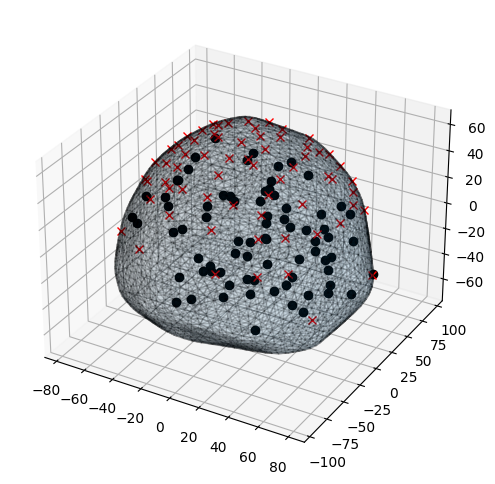

In [4]:
n_channels = len(mon_EEG.sensors.labels)
n_regions = len(conn.centres)

plt.figure(figsize = (6,6))
ax = plt.subplot(111, projection='3d')
# Plot cortical regions as black dots:
x, y, z = conn.centres.T[:,:]
ax.plot(x, y, z, 'ko')

# Plot EEG sensors as blue x's:
x, y, z = sens_eeg.sensors_to_surface(skin).T
ax.plot(x, y, z, 'rx')


# Plot boundary surface
x, y, z = skin.vertices.T
ax.plot_trisurf(x, y, z, triangles=skin.triangles, alpha=0.1, edgecolor='k')

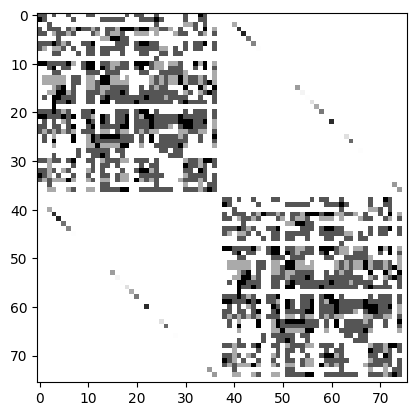

In [5]:
conn.region_labels[[21,22,30,31,32,34,59,60,68,69,70,72]]

conn.region_labels[[9, 21, 22, 30, 31, 32, 34, 59, 60, 62, 68, 69, 70, 72]]

plt.figure()
plt.imshow(conn.weights, cmap = 'binary')
plt.show()

# Generate data (resting-state)

Data will be generated from a network that uses for each node a modified JansenRit model that takes into account Abeta formation and accumulation, while the connectome will be adjusted to the empirical observations about amyloid-induced degeneration of brain connections. We will start by simulating resting-state data.

In [ ]:
#define impaired regions (taken from Braak stages)
impaired_regions = [21,22,30,31,32,34,59,60,68,69,70,72]
#######################################################################

'''We determine model parameters as explained in the paper (eqs 3 and 4), including a neuroplasticity parameter np
(which multiplies cp in the second row of equations 3)'''

n_steps = 50 #How many steps you want to use for changing t_e and t_i
a_array = np.linspace(0.100,0.112,n_steps) #This is the array of considered t_e values, TVB uses'a' as a parameter which is 1/t_e
b_array = np.linspace(0.05,0.025,n_steps) #This is the array of considered t_i values, TVB uses 'b' as a parameter which is 1/t_i

your_path = ''
structural_connectivities = np.load(your_path + 'structural_connectivities.npy')

#Define important constants
sim_time = 20000 #How long the simulation is gonna be by default
def Simulate(cp, lp, np_parameter, g, velocity, noise, regions = impaired_regions, stimulus = None, sim_time = sim_time):
    '''This function simulates signals at different levels of neurodegeneration parameters. The regions in which hypoinhibition is modelled are passed 
    through the "regions" argument which by default is equal to the "impaired_regions" listed above''' 

    con = connectivity.Connectivity.from_file('connectivity_76.zip') 
    con.weights = structural_connectivities[cp, np_parameter, :, :] #This alters the connectome according to equation 3 for a combination of cp and np
    # cp is comprised between o and 2 with 50 equal steps, while neuroplasticity is uniformally distributed between 0 and 2 with steps of 0.25 amplitude (plus a value of 2.5 at the end)
    con.weights = con.weights / np.max(con.weights)              #normalised by maximum weight  
    con.weights *= g
    con.speed = np.array(velocity)                               #To select conduction velocity of the signal
    con.configure()
    
    a_value = a_array[lp] #this determines the value of t_e
    b_value = b_array[lp] #this determines the value of t_i

    #altering inhibition in impaired regions:
    b_regions = np.ones(76)*0.05 #default value
    b_regions [regions]  = np.ones(len(regions)) * b_value # impairs b value (and therefore t_i) only in selected regions


    # setup model based on paper's parameters
    model_pars = dict(
        A=3.25, #excitatory PSP
        B=22, #inhibitory PSP
        v0=6.0,
        a=a_value, # increased with respect to the healthy case. (also remember that TVB uses ms, not s)
        b=b_regions,    # decreased with respect to the healthy case. (also remember that TVB uses ms, not s)
        r=0.56,
        nu_max=0.0025, # e0 in the JR original paper
        # TVB factors C_i into J*a_i, e.g. C1 = a_1 * J
        J=128,
        a_1=1.0,
        a_2=0.8,
        a_3= 0.25,
        a_4= 0.25,
        mu=0.22, # baseline input, avg of 120 and 320 pulses/s
    )

    # implement JR + afferent PSP for setting the JR in the right portion of the phase space
    class JRPSP(tvb.models.JansenRit):
        state_variable_range = Final(
            default={"y0": np.array([-1.0, 1.0]),
                     "y1": np.array([-500.0, 500.0]),
                     "y2": np.array([-50.0, 50.0]),
                     "y3": np.array([-6.0, 6.0]),
                     "y4": np.array([-20.0, 20.0]),
                     "y5": np.array([-500.0, 500.0]),
                     "y6": np.array([-20.0, 20.0]),
                     "y7": np.array([-500.0, 500.0])})

        variables_of_interest = List(
            of=str,
            label="Variables watched by Monitors",
            choices=("y0", "y1", "y2", "y3", "y4", "y5", "y6", "y7"),
            default=("y0", "y1", "y2", "y3"))

        state_variables = tuple('y0 y1 y2 y3 y4 y5 y6 y7'.split())
        _nvar = 8
        cvar = np.array([6], dtype=np.int32)

        def dfun(self, state_variables, coupling, local_coupling=0.0):
            dy = np.zeros((8, state_variables.shape[1], 1))
            # TVB's JR is eq 6 only
            dy[:6] = super().dfun(state_variables[:6], coupling, local_coupling)
            # tack on PSP for efferent following eq 8
            # NB with this, only y12 is coupling var for TVB
            y0, y1, y2, y3, y4, y5, y6, y7 = state_variables
            a_d = self.a / 3.0
            sigm_y1_y2 = 2.0 * self.nu_max / (1.0 + np.exp(self.r * (self.v0 - (y1 - y2))))
            dy[6] = y7
            dy[7] = self.A * a_d * sigm_y1_y2 - 2.0 * a_d * y7 - self.a**2 * y6
            return dy

    # factor out noise from dy4 = A a (p(t) + ...) as y4 += dt (...) + A a dW_t
    # this allows us to model the noise as TVB does it, though scaling requires experiment
    nsig = np.zeros((8, 76, 1))
    nsig[4] = model_pars['A'] * model_pars['a'] * (.320 - .120) * noise
    noise = tvb.noise.Additive(nsig=nsig)

    #setting up monitors:
    period = 1. #sampling time in terms of simulation time (total number of timepoints = sim_time / period)
    mon_tavg = monitors.TemporalAverage(period=period)
    mon_EEG.period=period
    #Bundling
    what_to_watch = (mon_tavg, mon_EEG)
    

    sim = simulator.Simulator(connectivity=con,
                              conduction_speed=np.float(con.speed),
                              model=JRPSP(
                              variables_of_interest=("y0", "y1", "y2", "y3", "y4", "y5", "y6", "y7"),
                              **{k: np.array(v) for k, v in model_pars.items()}),
                              coupling=tvb.coupling.Linear(a=np.r_[a_value*10]),
                              integrator=tvb.integrators.EulerStochastic(dt=0.1, noise=noise),
                              monitors=what_to_watch,
                              stimulus = stimulus,
                              simulation_length=sim_time)
    sim.configure()

    (ttavg, tavg), (teeg, eeg) = sim.run(simulation_length=sim_time) #tavg is the name of signals in region space

    return ttavg, tavg, teeg, eeg # ttavg and teeg are the timestamps
                           
                           
def preprocess(ttavg, tavg, teeg, eeg, PSD = True, normalize = True, cut = 1000):

    
    if PSD:
        #Discarding initial transient for PSD analysis
        ttavg = ttavg[cut:]
        tavg = tavg[cut:, :, :, :]
                           
        teeg = teeg[cut:]
        eeg = eeg[cut:, :, :, :]
        
        ttavg -= cut
        teeg -= cut
        

    if normalize:
        #Normalizing and subtracting average
        tavg /= (np.max(tavg,0) - np.min(tavg,0 ))
        tavg -= np.mean(tavg, 0)
        eeg /= (np.max(eeg,0) - np.min(eeg,0 ))
        eeg -= np.mean(eeg, 0)
                           
    return ttavg, tavg, teeg, eeg


simul_length = 4000
global_coupling_val = [0.1,1,10]
velocity_val = [1,10,np.inf]
noise_val = [50e-7, 50e-3, 5]

tavgs = np.zeros((len(global_coupling_val), len(velocity_val), len(noise_val), simul_length, n_regions))
eegs = np.zeros((len(global_coupling_val), len(velocity_val), len(noise_val), simul_length, n_channels))

for i in range(len(global_coupling_val)):
    for j in range(len(velocity_val)):
        for k in range(len(noise_val)):
            ttavg, tavg, teeg, eeg = Simulate(cp = 24, lp = 18, np_parameter = 4, g=global_coupling_val[i],
                                                              velocity=velocity_val[j], noise=noise_val[k], sim_time = simul_length)
#             ttavg, tavg_healthy, teeg, eeg_healthy = preprocess(ttavg, tavg_healthy, teeg, eeg_healthy) #if you want to preprocess
                                                                                                          
            tavgs[i,j,k,:,:] = tavg[:, 0, :, 0]
            eegs[i,j,k,:,:] = eeg[:, 0, :, 0]

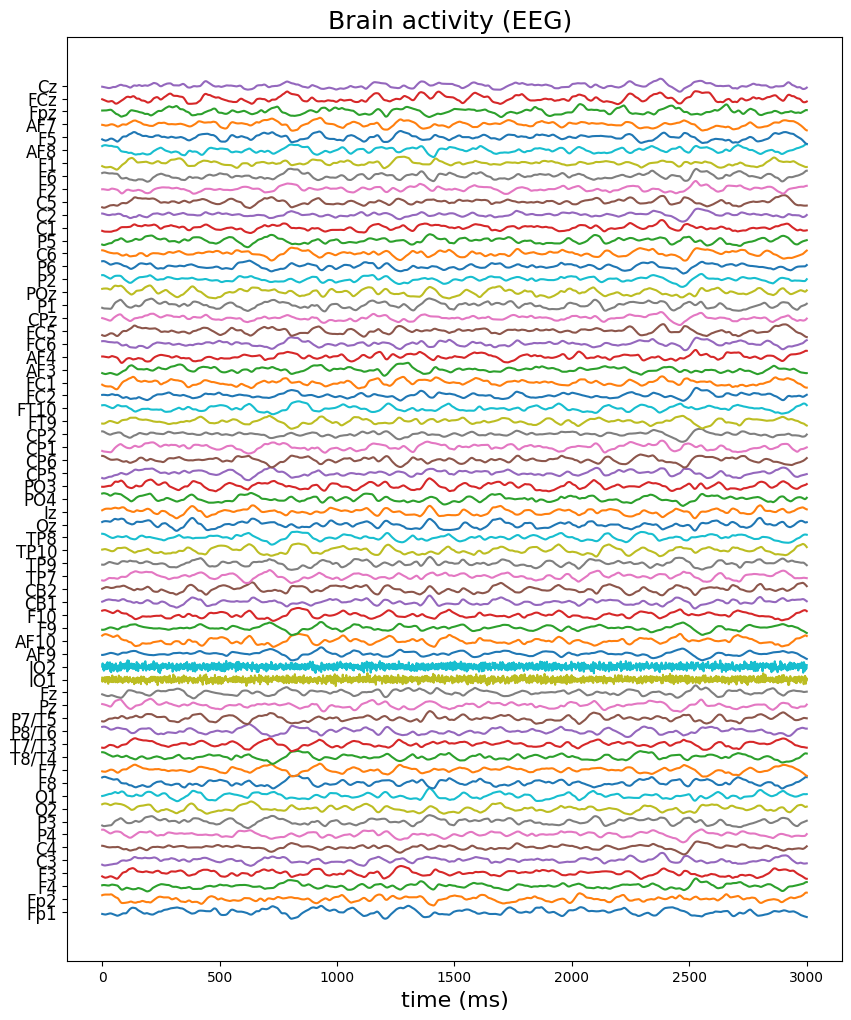

In [7]:
# dimensions of eegs are [global coupling, velocity, noise, time, channels]

eeg = eegs[0,2,2, 1000:, :]

eeg /= (np.max(eeg,0) - np.min(eeg,0 )) #normalization step
eeg -= np.mean(eeg, 0)  #re-referencing step

teeg = np.linspace(0,np.shape(eeg)[0], np.shape(eeg)[0]) #creating an array of time-steps


plt.figure(figsize=(10,12))
plt.plot(teeg, eeg + np.r_[:len(mon_EEG.sensors.labels)]) # the np.r_[:76] is addedd to separate channels or regions
plt.yticks(np.r_[:len(mon_EEG.sensors.labels)], mon_EEG.sensors.labels, fontsize = 12)
plt.title("Brain activity (EEG) ", fontsize = 18)
plt.xlabel('time (ms)', fontsize = 16)
plt.show()

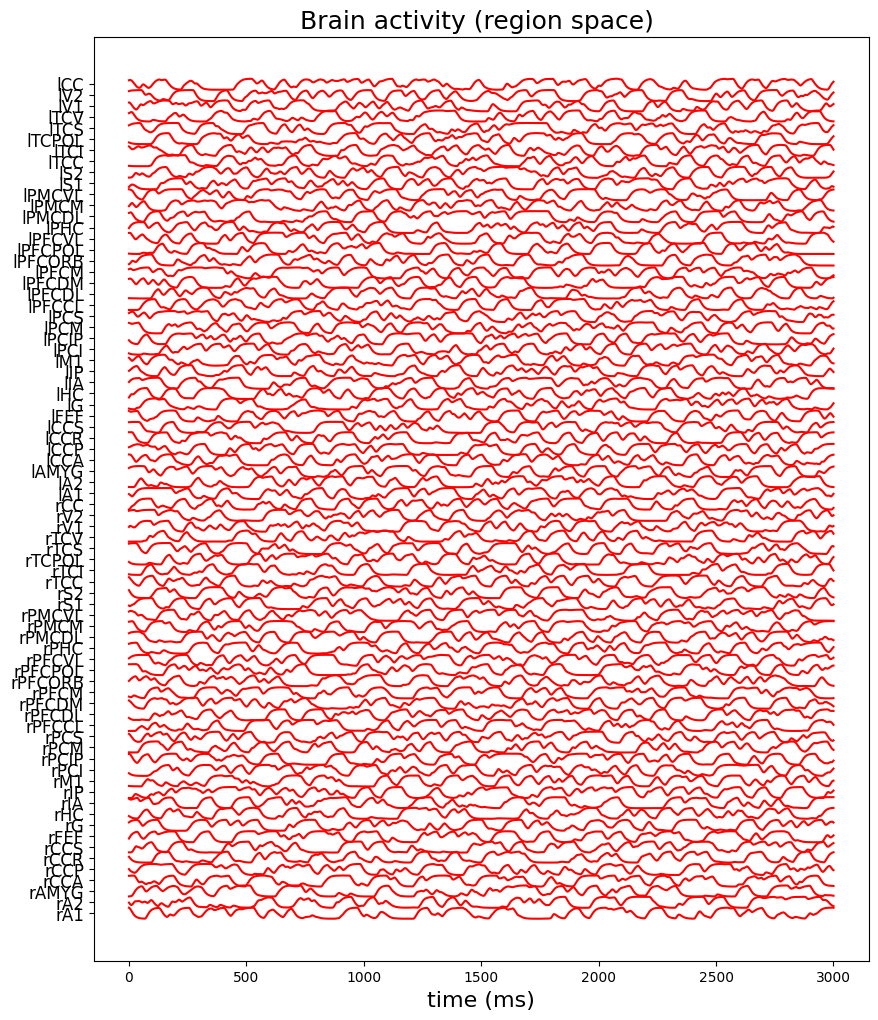

In [8]:
# dimensions of tavgs are [global coupling, velocity, noise, time, regions]

tavg = tavgs[0,2,2, 1000:, :]

tavg /= (np.max(tavg,0) - np.min(tavg,0 )) #normalization step
tavg -= np.mean(tavg, 0)  #re-referencing step

ttavg = np.linspace(0,np.shape(tavg)[0], np.shape(tavg)[0]) #creating an array of time-steps
# tavg = np.array([global_coupling, velocity, noise, n_times, n_channels])

plt.figure(figsize=(10,12))
plt.plot(ttavg, tavg + np.r_[:len(conn.region_labels)], color = 'red') # the np.r_[:76] is addedd to separate channels or regions
plt.yticks(np.r_[:len(conn.region_labels)], conn.region_labels, fontsize = 12)
plt.title("Brain activity (region space) ", fontsize = 18)
plt.xlabel('time (ms)', fontsize = 16)
plt.show()

# Simulated signals

Here we define parameters and feed them into the Simulate function to simulate electrophysiological activity. We will store and analyze both temporal average (tavg) of post-synaptic potential (PSP) and EEG. The tavg, being computed as a sum of AMPA-ergic EPSP and GABAa-ergic IPSP, can be seen as a mean-field proxy of the Local Field Potential.

In [ ]:
ttavg, tavg_healthy, teeg, eeg_healthy = Simulate(cp = 15, lp = 26, np_parameter = 3, g=1, velocity=np.inf, noise=50e-3,  #This is the standard value of neuroplasticity used in the paper
                                                  sim_time = 20000)
ttavg, tavg_healthy, teeg, eeg_healthy = preprocess(ttavg, tavg_healthy, teeg, eeg_healthy)

ttavg, tavg_MCI, teeg, eeg_MCI = Simulate(cp = 45, lp = 45, np_parameter = 3, g=1, velocity=np.inf, noise=50e-3,
                                        sim_time = 20000)
ttavg, tavg_MCI, teeg, eeg_MCI = preprocess(ttavg, tavg_MCI, teeg, eeg_MCI)

# In TVB the output for the JR (tavg or eeg) is a 4D object of dimensions [num_timestamps, num_modes, channels (or regions), 1] 
# The interesting variables are stored in the first and third argument, in which you find the timeseries of channels (if you refer to eeg)
# or the timeseries of regions (if you refer to tavg)

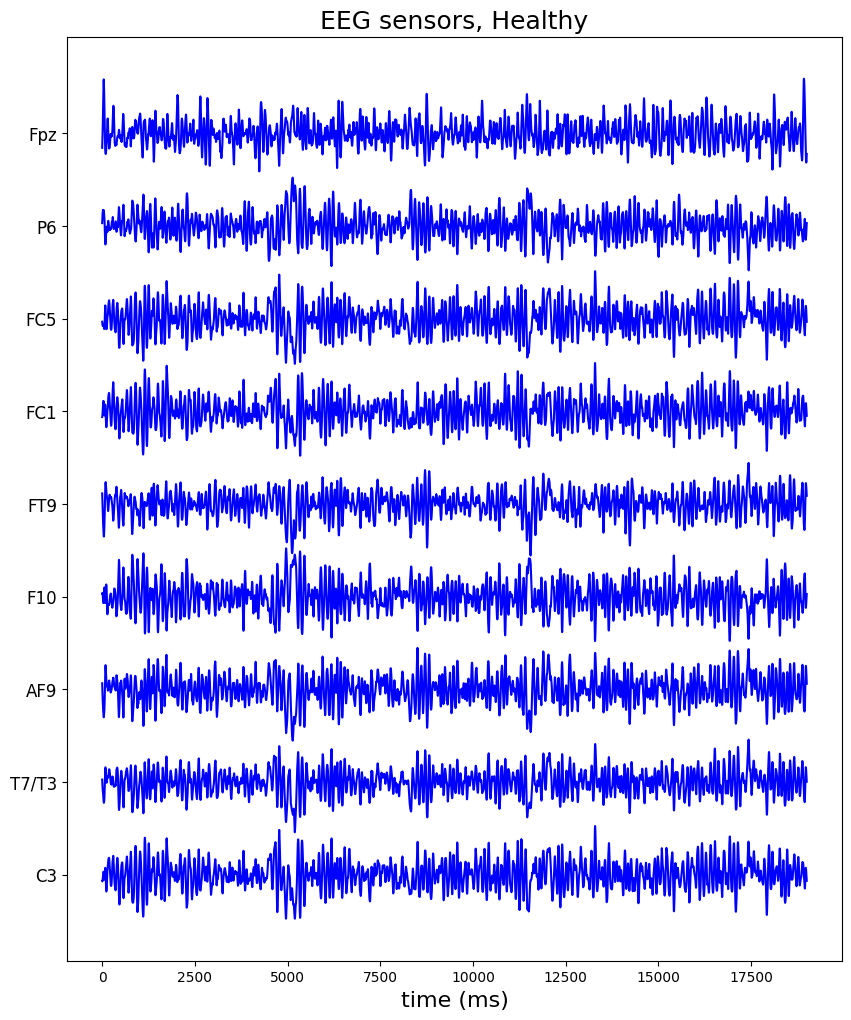

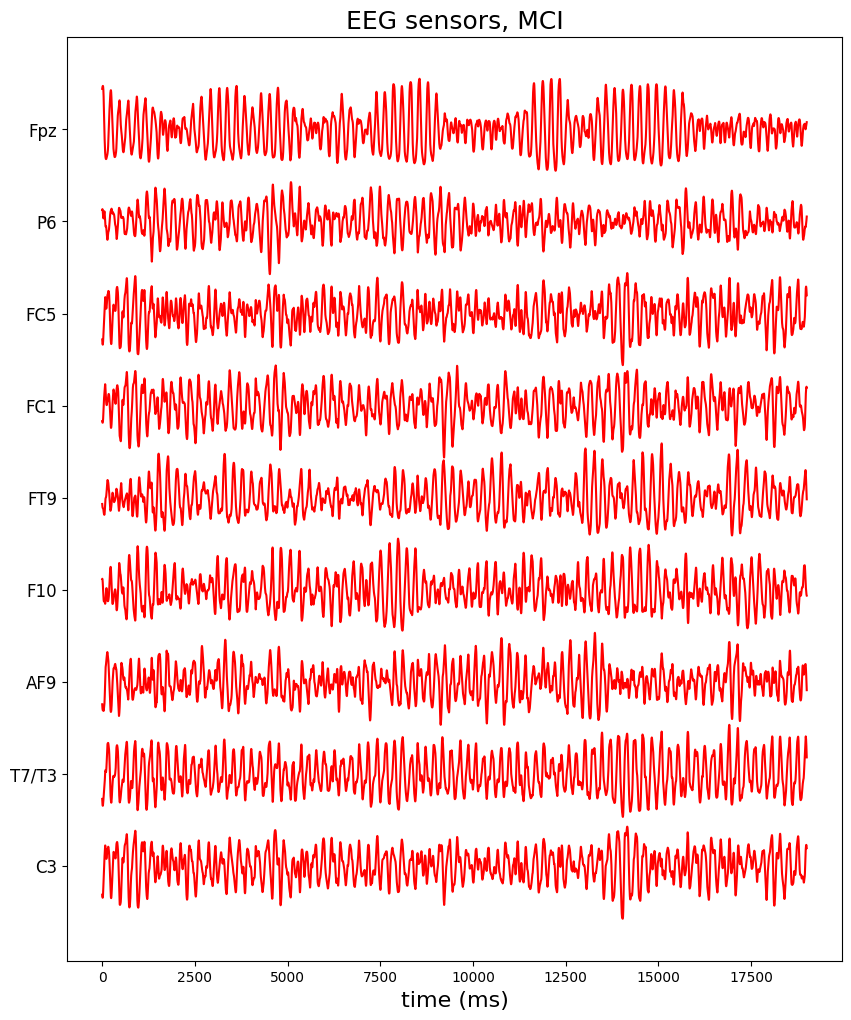

In [11]:
import matplotlib.animation as animation

datas = {'data_healthy': {'tavg': tavg_healthy, 'eeg': eeg_healthy, 'label': 'Healthy', 'color': 'blue'},
         'data_AD': {'tavg': tavg_MCI, 'eeg': eeg_MCI,  'label': 'MCI', 'color': 'red'}}

#Occipital EEG channels
chlist = [4,13, 20, 23,38,41, 45,50,62] #some channels to visualize data
display_time = sim_time - 1000


for key, value in datas.items():
    tavg = value['tavg']
    eeg = value['eeg']
    label = value['label']
    color = value['color']

    #Plot EEG
    plt.figure(figsize=(10,12))
    plt.plot(teeg[:display_time], eeg[:display_time, 0, chlist, 0] + np.r_[:(len(chlist))], color = color)
    plt.yticks(np.r_[:len(chlist)], mon_EEG.sensors.labels[chlist], fontsize = 12)
    plt.title("EEG sensors, " + label, fontsize = 18)
    plt.xlabel('time (ms)', fontsize = 16)
    plt.show()
    




#       # Create figure and axis  
#     fig, ax = plt.subplots(figsize=(10, 12))   #This is for animation, totally not needed but fun to watch

#     # Initialize the plot with empty data
#     lines = []
#     for i in range(len(chlist)):
#         line, = ax.plot([], [], color=color)
#         lines.append(line)

#     # Set axis labels and title
#     ax.set_title("EEG occipital sensors, " + label, fontsize=18)
#     ax.set_xlabel('time (ms)', fontsize=16)
#     ax.set_yticks(np.arange(len(chlist)))
#     ax.set_yticklabels(mon_EEG.sensors.labels[chlist], fontsize=12)

#     # Set limits for x and y axis
#     ax.set_xlim(-200, 8200)
#     ax.set_ylim(-1, len(chlist))

#     # Initialization function to set initial data
#     def init():
#         for line in lines:
#             line.set_data([], [])
#         return lines

#     # Update function to animate each frame
#     def update(frame, teeg = teeg, eeg = eeg):
#         for i, line in enumerate(lines):
#             x = teeg[:frame]
#             y = eeg[:frame, 0, chlist[i], 0] + i
#             line.set_data(x, y)
#         return lines
#     frames = np.arange(0, display_time, 10)
#     # Create animation
#     ani = animation.FuncAnimation(fig, update, frames=frames, init_func=init, blit=True, interval=1, repeat=False)
#     # Save the animation as an MP4 video file
#         # Display the animation
#     plt.show()
    
# ani.save('eeg_animation.gif', writer='pillow', fps=30, dpi=100) # The animation should appear only when saved



# Functional Connectivity

In here we will compute functional connectivity between brain regions and/or EEG electrodes.

###  Compute FC
The results of the simulation are stored as a  **4D-array**.
We need to turn it into one of TVB's time series datatypes, which is what the interactive plotting tool operate on, in this case we are using **TimeSeriesRegion** (i.e., region-based simulation).


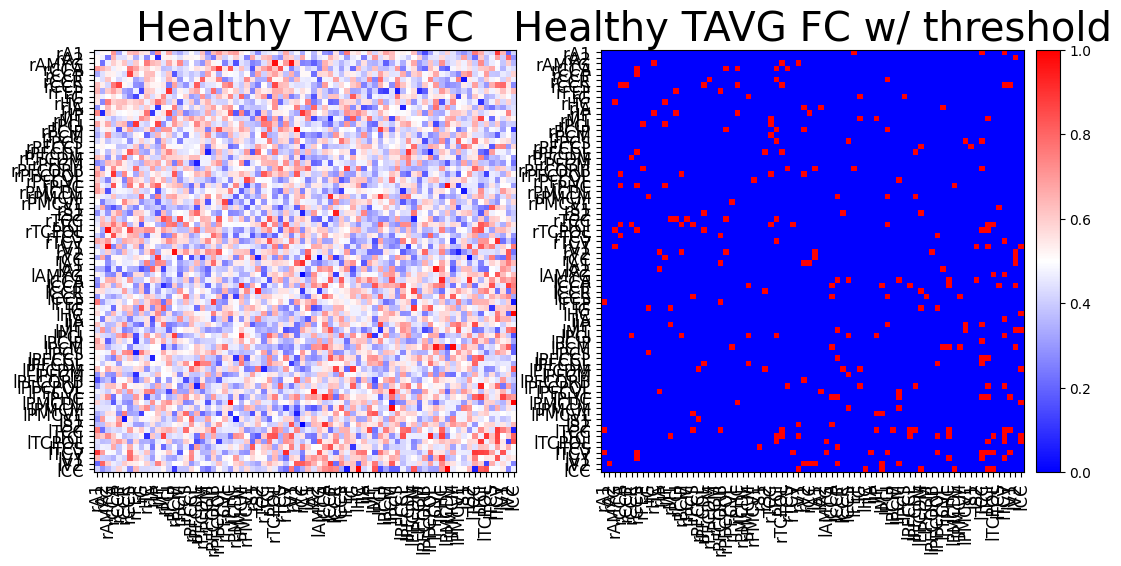

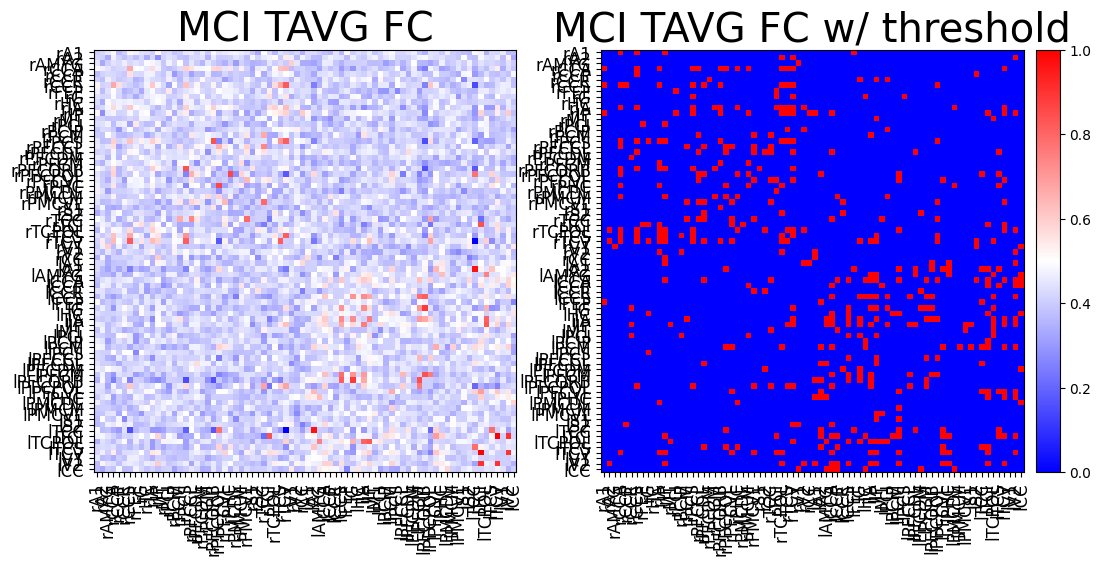

In [12]:
#Define a function to compute Functional Connectivity
period = 1. #The same used in Simulate function
def ev(time_series):
    
    tsr = TimeSeriesRegion(connectivity=conn,
                       data=time_series,                            #in TVB 4D format
                       sample_period=period) #in ms
    tsr.configure()
    
    input_shape = tsr.data.shape
    result_shape = (input_shape[2], input_shape[2], input_shape[1], input_shape[3])
    result = np.zeros(result_shape)

    for mode in range(result_shape[3]):
        for var in range(result_shape[2]):
            data = tsr.data[:,var,:, mode].squeeze()
            result[:, :, var, mode] = np.corrcoef(data.T)

    corr_coeff = graph.CorrelationCoefficients(source=tsr, array_data=result)
    
    return corr_coeff

def functional_connectivity(time_series, th=0.08):

#     time_series = time_series[np.isnan(time_series)]
    tsr_corr = ev(time_series)

    corr= tsr_corr.array_data[..., 0, 0]
    
    corr -= np.eye(len(time_series[0,0,:,0]))

    #Define a threshold for connections
    th = th 

    corr_th = (corr) > th

    pmatrix = np.zeros((len(time_series[0,0,:,0]),len(time_series[0,0,:,0])))

    for i in range(len(time_series[0,0,:,0])):
        for j in range(len(time_series[0,0,:,0])):
            
            region_A = time_series[:,0, i, 0]
            region_B = time_series[:,0, j, 0]
            
            pmatrix[i][j] = pearsonr(region_A, region_B)[1]

    pmatrix_th = pmatrix < 0.05

    corr_th_significance = np.multiply(corr_th, pmatrix_th)

    return corr, corr_th


for key, value in datas.items():
    tavg = value['tavg']
    eeg = value['eeg']
    label = value['label']
    color = value['color']

    corr_tavg, corr_tavg_th = functional_connectivity(tavg)
    corr_eeg, corr_eeg_th = functional_connectivity(eeg)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

    # Plot corr_tavg
    im1 = ax1.imshow(corr_tavg, interpolation='nearest', cmap='bwr')
    ax1.set_yticks(np.arange(len(conn.region_labels)))
    ax1.set_yticklabels(conn.region_labels, fontsize=12)
    ax1.set_xticks(np.arange(len(conn.region_labels)))
    ax1.set_xticklabels(conn.region_labels, rotation='vertical', fontsize=12)
    ax1.set_title(label+' TAVG FC', fontsize=29)

    # Plot corr_tavg_th
    im2 = ax2.imshow(corr_tavg_th, interpolation='nearest', cmap='bwr')
    ax2.set_yticks(np.arange(len(conn.region_labels)))
    ax2.set_yticklabels(conn.region_labels, fontsize=12)
    ax2.set_xticks(np.arange(len(conn.region_labels)))
    ax2.set_xticklabels(conn.region_labels, rotation='vertical', fontsize=12)
    ax2.set_title(label+' TAVG FC w/ threshold', fontsize=29)

    # Colorbar
    cax = fig.add_axes([ax2.get_position().x1 + 0.01, ax2.get_position().y0, 0.02, ax2.get_position().height])
    cbar = plt.colorbar(im2, cax=cax)

    plt.show()



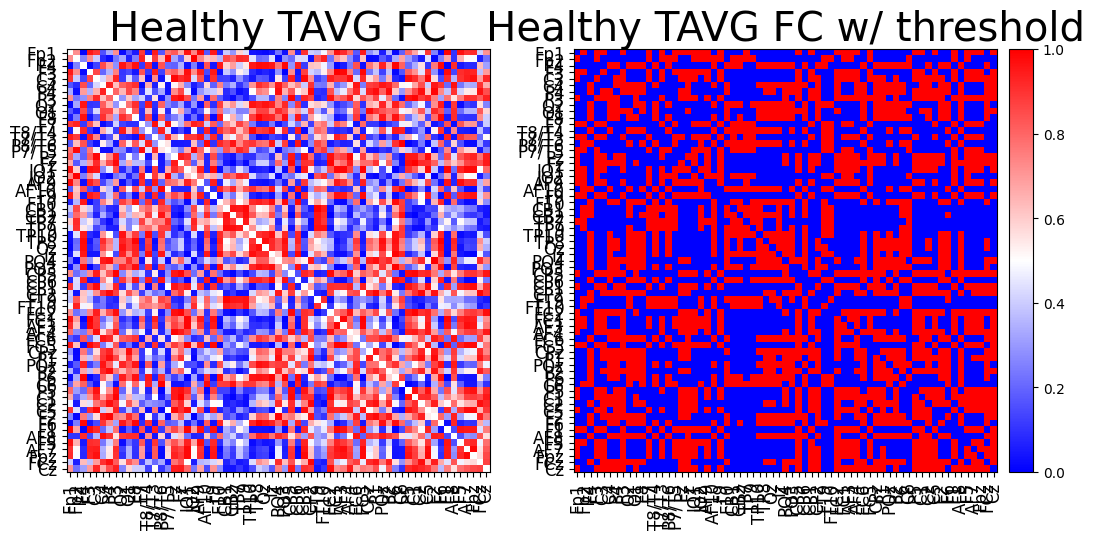

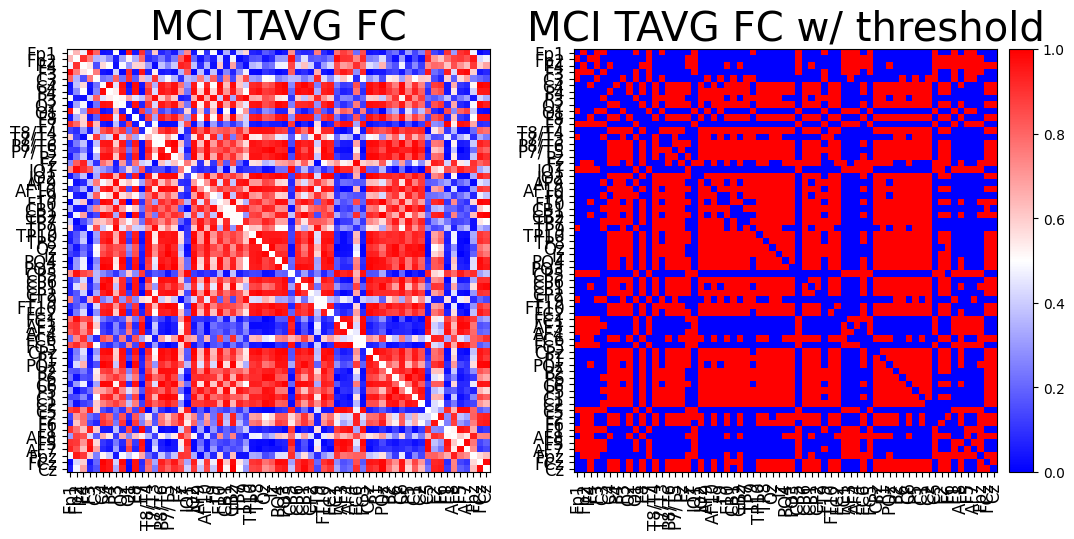

In [13]:


# Define a bandpass filter, e.g. for the alpha band (8-13 Hz)
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data, axis=0)
    return y

# Define a function to compute Functional Connectivity in the desired band
period = 1.  # The same used in Simulate function (1 ms sample period)
def ev_alpha(time_series_filtered):
    
    tsr = TimeSeriesRegion(connectivity=conn,
                           data=time_series_filtered,                # in TVB 4D format
                           sample_period=period)                    # in ms
    tsr.configure()
    
    input_shape = tsr.data.shape
    result_shape = (input_shape[2], input_shape[2], input_shape[1], input_shape[3])
    result = np.zeros(result_shape)

    for mode in range(result_shape[3]):
        for var in range(result_shape[2]):
            data = tsr.data[:, var, :, mode].squeeze()
            result[:, :, var, mode] = np.corrcoef(data.T)

    corr_coeff = graph.CorrelationCoefficients(source=tsr, array_data=result)
    
    return corr_coeff

# Define the functional connectivity function with alpha band filtering
def functional_connectivity_alpha(time_series, fs=1000, th=0.1, lowcutfreq = 8, highcutfreq = 13):
    # fs is the sampling frequency (1000 Hz here)
    
    # Apply bandpass filter to the time series (8-13 Hz for alpha band)
    filtered_time_series = np.zeros_like(time_series)
    
    for i in range(time_series.shape[2]):
        for j in range(time_series.shape[3]):
            filtered_time_series[:, 0, i, j] = bandpass_filter(time_series[:, 0, i, j], lowcutfreq, highcutfreq, fs)
    
    # Compute correlation matrix on filtered data
    tsr_corr = ev_alpha(filtered_time_series)

    corr = tsr_corr.array_data[..., 0, 0]
    corr -= np.eye(len(time_series[0, 0, :, 0]))

    # Define a threshold for connections
    corr_th = corr > th

    # Compute p-values for each connection (null hypothesis: no correlation)
    pmatrix = np.zeros((len(time_series[0, 0, :, 0]), len(time_series[0, 0, :, 0])))

    for i in range(len(time_series[0, 0, :, 0])):
        for j in range(len(time_series[0, 0, :, 0])):
            region_A = filtered_time_series[:, 0, i, 0]
            region_B = filtered_time_series[:, 0, j, 0]
            pmatrix[i, j] = pearsonr(region_A, region_B)[1]

    # Threshold p-values for significance
    pmatrix_th = pmatrix < 0.05

    # Final correlation matrix with significance
    corr_th_significance = np.multiply(corr_th, pmatrix_th)

    return corr, corr_th_significance


for key, value in datas.items():
    tavg = value['tavg']
    eeg = value['eeg']
    label = value['label']
    color = value['color']

    corr_tavg, corr_tavg_th = functional_connectivity_alpha(tavg)
    corr_eeg, corr_eeg_th = functional_connectivity_alpha(eeg)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

    # Plot corr_tavg
    im1 = ax1.imshow(corr_eeg, interpolation='nearest', cmap='bwr')
    ax1.set_yticks(np.arange(len(mon_EEG.sensors.labels)))
    ax1.set_yticklabels(mon_EEG.sensors.labels, fontsize=12)
    ax1.set_xticks(np.arange(len(mon_EEG.sensors.labels)))
    ax1.set_xticklabels(mon_EEG.sensors.labels, rotation='vertical', fontsize=12)
    ax1.set_title(label+' TAVG FC', fontsize=29)

    # Plot corr_tavg_th
    im2 = ax2.imshow(corr_eeg_th, interpolation='nearest', cmap='bwr')
    ax2.set_yticks(np.arange(len(mon_EEG.sensors.labels)))
    ax2.set_yticklabels(mon_EEG.sensors.labels, fontsize=12)
    ax2.set_xticks(np.arange(len(mon_EEG.sensors.labels)))
    ax2.set_xticklabels(mon_EEG.sensors.labels, rotation='vertical', fontsize=12)
    ax2.set_title(label+' TAVG FC w/ threshold', fontsize=29)

    # Colorbar
    cax = fig.add_axes([ax2.get_position().x1 + 0.01, ax2.get_position().y0, 0.02, ax2.get_position().height])
    cbar = plt.colorbar(im2, cax=cax)

    plt.show()


# PSD WELCH:

Now we will display PSD of the two signals using Welch method.

### Compute PSD
Firstly, we will obtain and plot the mean time series of TAVG and EEG, 
later we will generate the band-passed version of the Power spectrum 
calculated with Welch method.

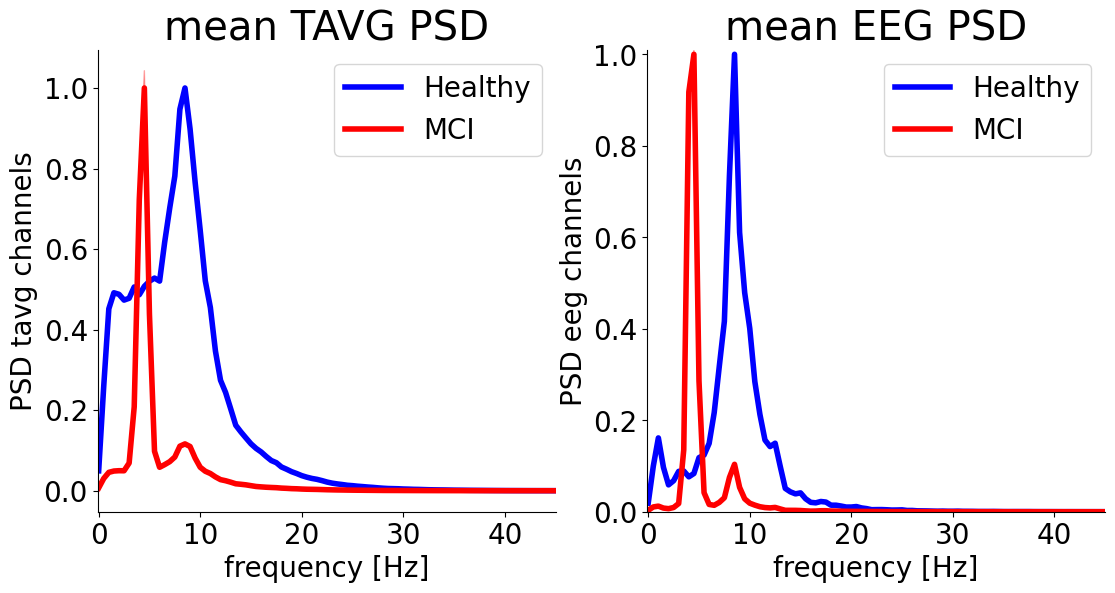

In [14]:


freq_sample = 1024



lowcut = 0.5
highcut = 45
order = 4

n_seg = 2048
freq_sample = n_seg//2
freq = freq_sample+1 
window = 'hamming'



def filter_bandpass(signal, lowcut, highcut, fs):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    signal_bp = filtfilt(b, a, signal, axis = 0)
    return signal_bp


def compute_psd(time_series): 
    
    signal_bp = np.zeros((len(time_series[:,0,0,0]), len(time_series[0,0,:,0])))


    Welch_signal_bp = np.zeros((freq, freq, len(time_series[0,0,:,0])))
    
    for i in range (len(time_series[0,0,:,0])):
        signal_bp[:,i] = filter_bandpass(time_series[:,0,i,0], lowcut, highcut, freq_sample)
        Welch_signal_bp[:, 0, i], Welch_signal_bp[0, :, i] = signal.welch(signal_bp[:,i],
                                                                                    freq_sample, nperseg=n_seg, 
                                                                                    noverlap=n_seg//2, window=window)
        
    
    welch_mean = np.mean(Welch_signal_bp[0, :, :], axis = 1)
    welch_mean /= np.max(welch_mean) #Normalize
    welch_sem =  np.std(Welch_signal_bp[0, :, :], axis = 1)
    welch_sem /= np.max(welch_mean) #Normalize
    
    return Welch_signal_bp[:, 0, 0], welch_mean, welch_sem
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
    
for key, value in datas.items():
    tavg = value['tavg']
    eeg = value['eeg']
    label = value['label']
    color = value['color']
    
    
    freqs_tavg, psd_tavg_mean, psd_tavg_sem = compute_psd(tavg)
    freqs_eeg, psd_eeg_mean, psd_eeg_sem = compute_psd(eeg)
    
    ax1.plot(freqs_tavg, psd_tavg_mean, label = label, linewidth = 4, color = color)
    ax1.fill_between(freqs_tavg, psd_tavg_mean + psd_tavg_sem, psd_tavg_mean - psd_tavg_sem, where = None, alpha = 0.35,  color = color)
    
    ax2.plot(freqs_eeg, psd_eeg_mean, label = label, linewidth = 4, color = color)
    ax2.fill_between(freqs_eeg, psd_eeg_mean + psd_eeg_sem, psd_eeg_mean - psd_eeg_sem, where = None, alpha = 0.35, color = color)

    
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_title('mean TAVG PSD', fontsize = 29)
ax2.set_ylim(0, 1.01)
ax1.set_xlim(-0.1, 45)
ax1.set_xlabel('frequency [Hz]', fontsize = 20)
ax1.set_ylabel('PSD tavg channels', fontsize = 20)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.set_xticklabels([0,0,10,20,30,40])
ax1.legend(fontsize = 20)
#ax1.set_yscale('log')


ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_title('mean EEG PSD', fontsize = 29)
ax2.set_ylim(0, 1.01)
ax2.set_xlim(-0.1, 45)
ax2.set_xlabel('frequency [Hz]', fontsize = 20)
ax2.set_ylabel('PSD eeg channels', fontsize = 20)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.set_xticklabels([0,0,10,20,30,40])
ax2.legend(fontsize = 20)
#ax2.set_yscale('log')

plt.show()  

# Generate data (3-CVT)

We will now generate simulated 3-CVT data, by injecting a square wave in regions corresponding to the ventral stream of visual information (from V1 to the pole of temporal cortex). Alterations due to AD progression will be introduced in a similar fashion to what was done for resting-state data.

In [15]:

nnode = conn.weights.shape[0]
#This will inject the virtual stimulus in wanted regions
class MultiStimuliRegion(patterns.StimuliRegion):
    connectivity = Attr(connectivity.Connectivity, required=False)
    temporal = Attr(field_type=equations.TemporalApplicableEquation, required=False)
    weight = NArray(required=False)
    
    def __init__(self, *stimuli):
        super(MultiStimuliRegion, self).__init__()
        self.stimuli = stimuli
    def configure_space(self, *args, **kwds):
        [stim.configure_space(*args, **kwds) for stim in self.stimuli]
    def configure_time(self, *args, **kwds):
        [stim.configure_time(*args, **kwds) for stim in self.stimuli]
    def __call__(self, *args, **kwds):
        return np.array([stim(*args, **kwds) for stim in self.stimuli]).sum(axis=0)
    

def make_train(node_idx, node_weights, stimweight = 1, **params):
    weighting = np.zeros(nnode)
    weighting[node_idx] = node_weights
    eqn_t = equations.PulseTrain()
    eqn_t.parameters.update(params)
    stimulus = patterns.StimuliRegion(
        temporal=eqn_t,
        connectivity=conn,
        weight=weighting)
    return stimulus

stimweight = 1
scalefact = 10
starttime = 500

train1 = make_train([35,73], 5.0/stimweight, onset=starttime , T=1000.0, tau=40.0) #500
train2 = make_train([36,74], 4.5/stimweight, onset=starttime + 10 * scalefact, T=1000, tau=50.0) #600
train3 = make_train([34,72], 4.0/stimweight, onset=starttime + 35 * scalefact, T=1000, tau=80.0) #850
train4 = make_train([32,70], 4.0/stimweight, onset=starttime + 40 * scalefact, T=1000, tau=80.0) #900
train5 = make_train([24,62], 4.0/stimweight, onset=starttime + 50 * scalefact, T=1000, tau=80.0) #1000
stimulus = MultiStimuliRegion(train1, train2,train3, train4, train5)
stimulus.configure_space()
time = np.r_[1e3:3e3:15.0]
stimulus.configure_time(time)
pattern = stimulus()



def mean_channels(mask1, mask2, signal, chlist):
    summ = 0
    for ch in chlist:
        summ += signal[mask1:mask2, 0, ch, 0]
    summ /= len(chlist)
    return summ

def std_channels(mask1, mask2, signal, chlist):
    summ = 0
    mean = mean_channels(mask1, mask2, signal, chlist)
    for ch in chlist:
        summ += (signal[mask1:mask2, 0, ch, 0] - mean)**2
    #summ = sqrt(summ)
    summ /= len(chlist)-1
    return summ

WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\tnela\OneDrive\Desktop\LGA\TVB\TVB_Distribution\tvb_data\Lib\logging\handlers.py", line 74, in emit
    self.doRollover()
  File "C:\Users\tnela\OneDrive\Desktop\LGA\TVB\TVB_Distribution\tvb_data\Lib\logging\handlers.py", line 435, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\Users\tnela\OneDrive\Desktop\LGA\TVB\TVB_Distribution\tvb_data\Lib\logging\handlers.py", line 115, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\tnela\\.tvb-temp\\logs\\library.log' -> 'C:\\Users\\tnela\\.tvb-temp\\logs\\library.log.2025-04-29'
Call stack:
  File "C:\Users\tnela\OneDrive\Desktop\LGA\TVB\TVB_Distribution\tvb_data\Lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\tnela\OneDrive\Desktop\LGA\TVB\TVB_Distribution\tvb_data\Lib\runpy.py",

WARNING  File 'hemispheres' not found in ZIP.


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\tnela\OneDrive\Desktop\LGA\TVB\TVB_Distribution\tvb_data\Lib\logging\handlers.py", line 74, in emit
    self.doRollover()
  File "C:\Users\tnela\OneDrive\Desktop\LGA\TVB\TVB_Distribution\tvb_data\Lib\logging\handlers.py", line 435, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\Users\tnela\OneDrive\Desktop\LGA\TVB\TVB_Distribution\tvb_data\Lib\logging\handlers.py", line 115, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\tnela\\.tvb-temp\\logs\\library.log' -> 'C:\\Users\\tnela\\.tvb-temp\\logs\\library.log.2025-04-29'
Call stack:
  File "C:\Users\tnela\OneDrive\Desktop\LGA\TVB\TVB_Distribution\tvb_data\Lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\tnela\OneDrive\Desktop\LGA\TVB\TVB_Distribution\tvb_data\Lib\runpy.py",

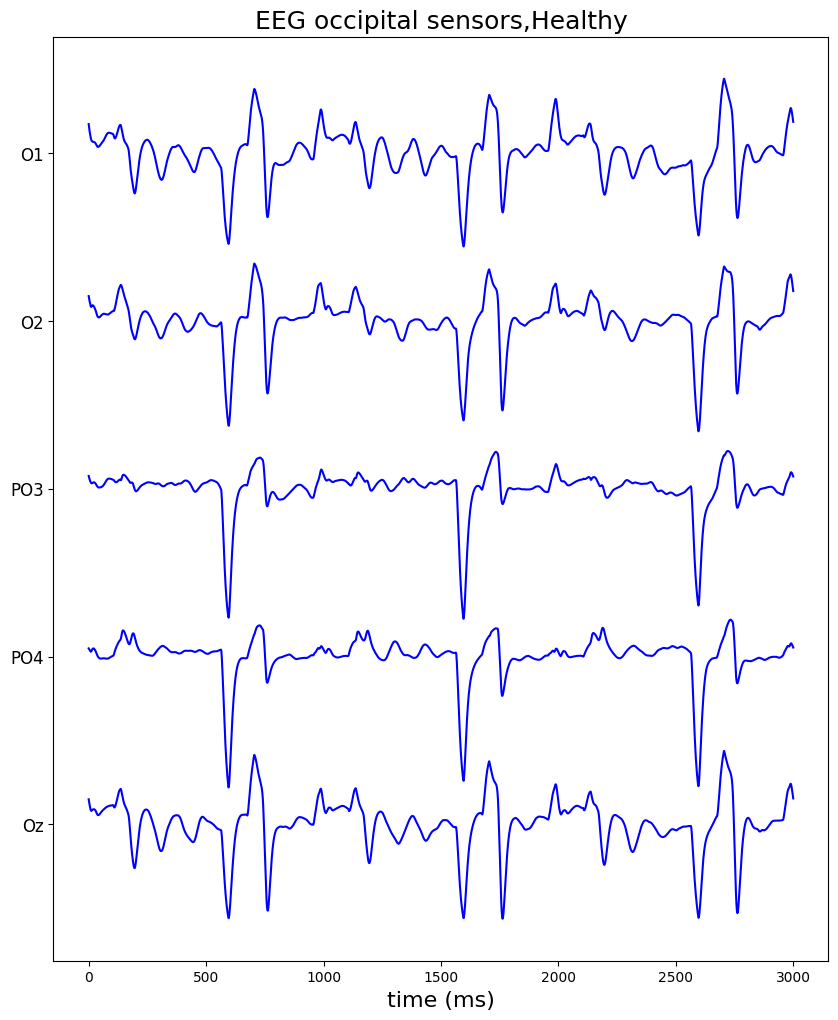

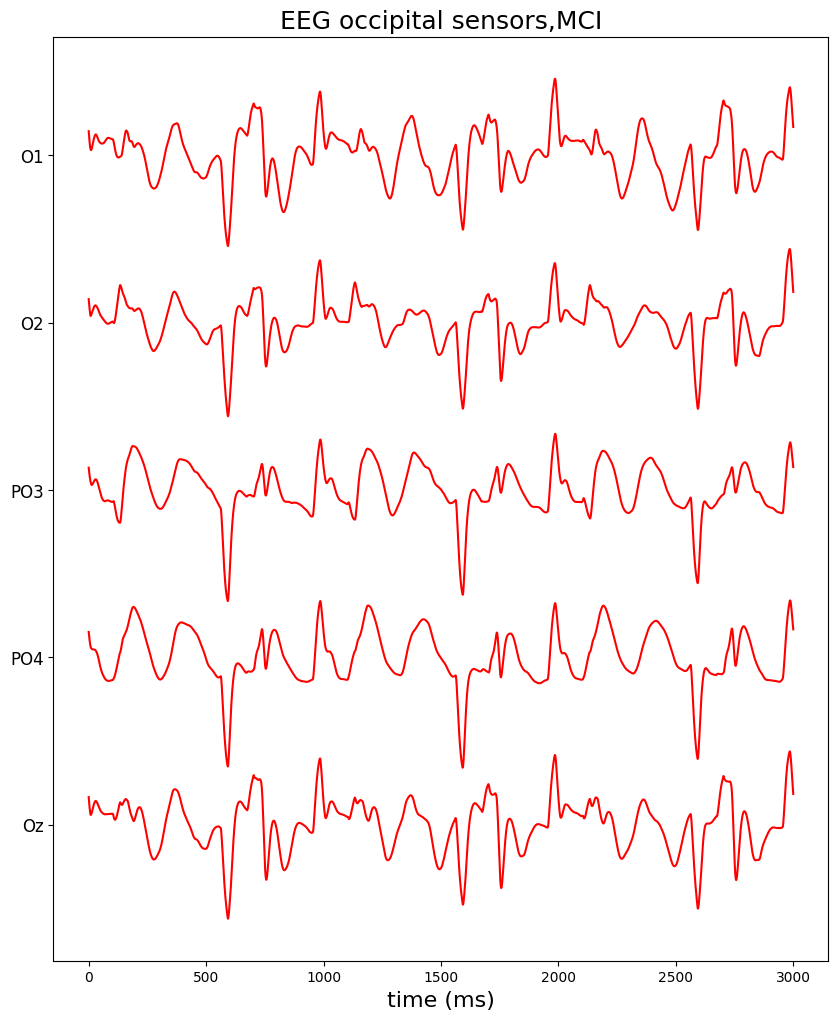

In [20]:
#Load connectivity
conn =  connectivity.Connectivity.from_file('connectivity_76.zip')


ttavg_stim, tavg_healthy_stim, teeg_stim, eeg_healthy_stim = Simulate(cp = 15, lp = 26, np_parameter = 3, g=1, velocity=np.inf, noise=50e-3, 
                                                stimulus = stimulus, sim_time = 4000) #Less simulated time needed
ttavg_stim, tavg_healthy_stim, teeg_stim, eeg_healthy_stim = preprocess(ttavg_stim, tavg_healthy_stim, teeg_stim, eeg_healthy_stim)


ttavg_stim, tavg_MCI_stim, teeg_stim, eeg_MCI_stim = Simulate(cp = 24, lp = 48, np_parameter = 3, g=1, velocity=np.inf, noise=50e-3,  stimulus = stimulus, sim_time = 4000) #Less simulated time needed
ttavg_stim, tavg_MCI_stim, teeg_stim, eeg_MCI_stim = preprocess(ttavg_stim, tavg_MCI_stim, teeg_stim, eeg_MCI_stim)



datas_stim = {'data_healthy': {'tavg': tavg_healthy_stim, 'eeg': eeg_healthy_stim, 'label': 'Healthy', 'color': 'blue'},
         'data_MCI': {'tavg': tavg_MCI_stim, 'eeg': eeg_MCI_stim,  'label': 'MCI', 'color': 'red'}}

#Occipital EEG channels
chlist_occipital = [30,32,33,8,9]
display_time = sim_time - 2000



for key, value in datas_stim.items():
    tavg_stim = value['tavg']
    eeg_stim = value['eeg']
    label = value['label']
    color = value['color']

    #Plot EEG
    plt.figure(figsize=(10,12))
    plt.plot(teeg_stim[:display_time], eeg_stim[:display_time, 0, chlist_occipital, 0] + np.r_[:(len(chlist_occipital))], color = color)
    plt.yticks(np.r_[:len(chlist_occipital)], mon_EEG.sensors.labels[chlist_occipital], fontsize = 12)
    plt.title("EEG occipital sensors," + label, fontsize = 18)
    plt.xlabel('time (ms)', fontsize = 16)
    plt.show()

    

Healthy N1 depth is: -0.6441709647772799
MCI N1 depth is: -0.543662296616438


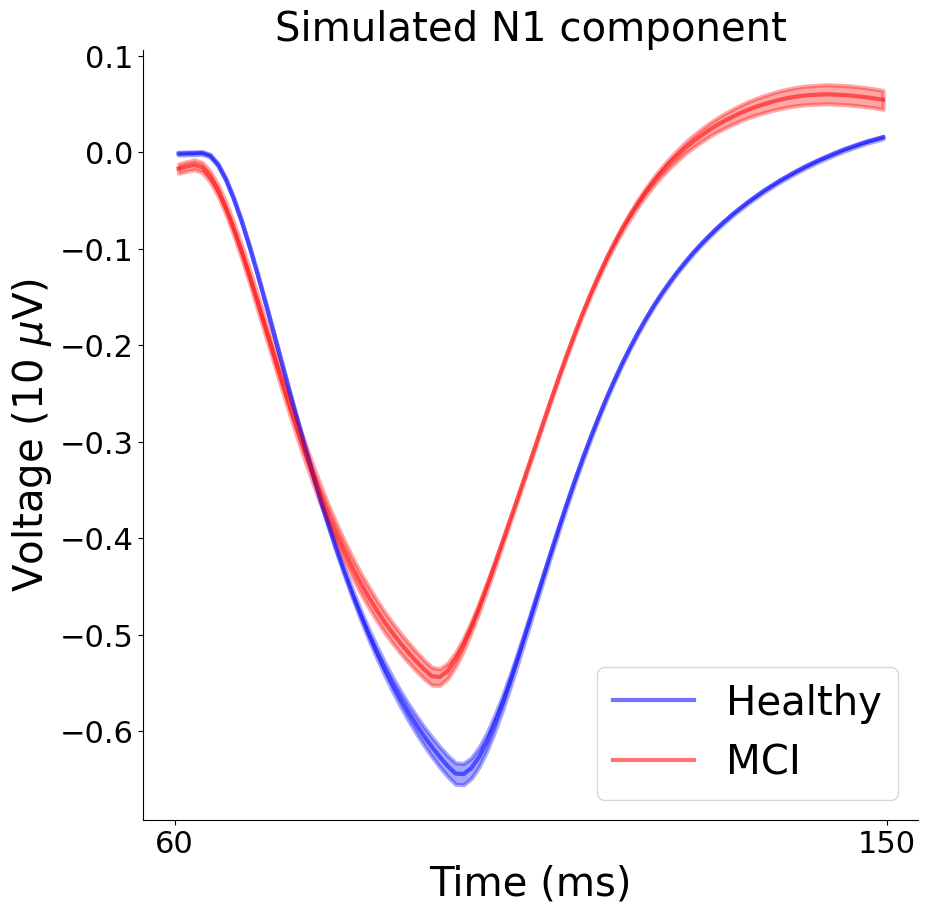

In [21]:
################################## USEFUL ONLY WHEN STIMULUS IS APPLIED ###################################################

#1500 is stimulus onset 
onset_stim = 1500
mask1 = onset_stim + 60
mask2  = onset_stim + 150



chlist_occipital = [30,32,33,8,9]

chlist = chlist_occipital



plt.figure(figsize=(10,10))
for key, value in datas_stim.items():
    
    tavg_stim = value['tavg']
    eeg_stim = value['eeg']
    label = value['label']
    color = value['color']
    
    mean_n1 = mean_channels(mask1,mask2,eeg_stim,chlist)
    std_n1 =  std_channels(mask1,mask2,eeg_stim,chlist)
    
    plt.plot(teeg_stim[mask1:mask2], mean_n1, color = color, linewidth = 3, alpha = 0.55, label =  label)
    plt.fill_between(teeg_stim[mask1:mask2], mean_n1 + std_n1, mean_n1 - std_n1, color = color, linewidth = 3, alpha = 0.35 )
        
    print(label, 'N1 depth is:', np.min(mean_n1))

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title("Simulated N1 component", fontsize = 29)
plt.xlabel('Time (ms)', fontsize = 29)
plt.ylabel(r'Voltage (10 $\mu$V)', fontsize = 29)
plt.xticks([mask1,mask2], [mask1-onset_stim,mask2-onset_stim], fontsize = 22) #1500 is stimulus onset 
plt.yticks(fontsize = 22)
plt.legend(fontsize = 29)
plt.show()


